In [1]:
# 导入相关的库
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 使用Pandas读取数据

In [2]:
# 读取csv文件
df_data = pd.read_csv("EtherPriceHistory(USD).csv") 
print(df_data.tail())
print('*' * 50)
print(type(df_data))

      Date(UTC)  UnixTimeStamp   Value
1159  10/1/2018     1538352000  230.89
1160  10/2/2018     1538438400  225.41
1161  10/3/2018     1538524800  219.97
1162  10/4/2018     1538611200  221.76
1163  10/5/2018     1538697600  227.90
**************************************************
<class 'pandas.core.frame.DataFrame'>


In [3]:
df_data = pd.read_csv("EtherPriceHistory(USD).csv", # 修改日期格式，并将其作为index
                      parse_dates=['Date(UTC)'], index_col='Date(UTC)')
df_data = df_data[['Value']] # 提取df_data中'Value'列
print(type(df_data))
print(df_data.tail(3))

<class 'pandas.core.frame.DataFrame'>
             Value
Date(UTC)         
2018-10-03  219.97
2018-10-04  221.76
2018-10-05  227.90


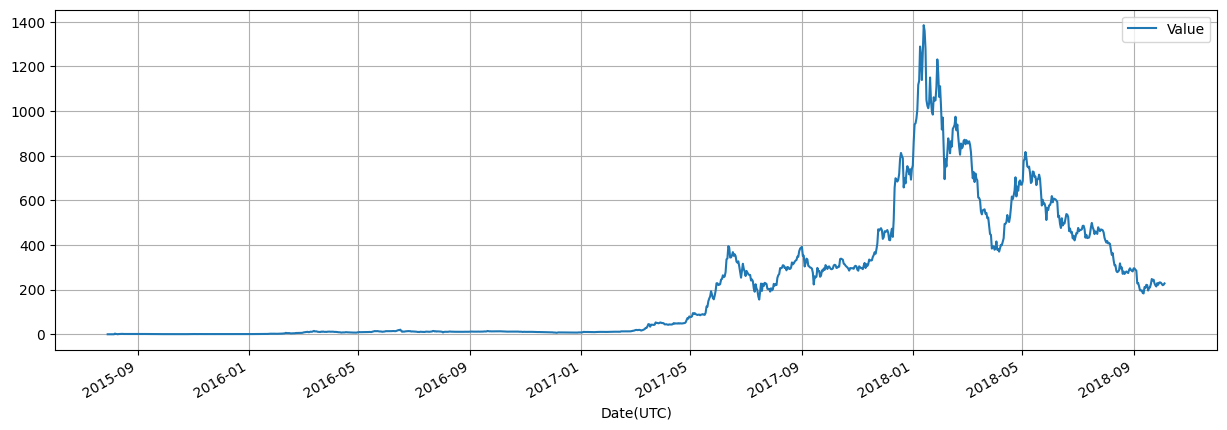

In [4]:
df_data.plot(figsize=(15, 5), grid=True);

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1)) # 对数据执行最大-最小缩放
df_data['Value'] = scaler.fit_transform(df_data['Value'].values.reshape(-1,1))
print(df_data.tail())

               Value
Date(UTC)           
2018-10-01 -0.666590
2018-10-02 -0.674503
2018-10-03 -0.682358
2018-10-04 -0.679774
2018-10-05 -0.670907


## 定义训练及测试数据集

In [6]:
# 设置划分训练数据和测试数据的阈值参数
threshold = 190
train_data = df_data['Value'][:len(df_data)-threshold]
test_data = df_data['Value'][len(df_data)-threshold:]

print(test_data.head(3))
print('*' * 50)
print(type(train_data))
print('*' * 50)
print('训练数据长度为：', len(train_data))
print('测试数据长度为：', len(test_data))

Date(UTC)
2018-03-30   -0.431315
2018-03-31   -0.430954
2018-04-01   -0.452932
Name: Value, dtype: float64
**************************************************
<class 'pandas.core.series.Series'>
**************************************************
训练数据长度为： 974
测试数据长度为： 190


In [7]:
# 基于训练/测试数据构建训练集/测试集的样本（包括输入、输出）
def create_sequences(input_data, window):
    length = len(input_data) # 获取训练/测试数据的长度
    x = input_data[0:window].values # 构建第一个样本的输入
    y = input_data[1:window+1].values # 构建第一个样本的输出
    for i in range(1, length - window): # 依次构建其余样本（样本数量=样本数据长度-序列长度）
        x = np.vstack((x, input_data[i:i+window].values))
        y = np.vstack((y, input_data[i+1:window+1+i].values))
        
        sequence = torch.from_numpy(x).type(torch.FloatTensor) # 将输入/输出转化为张量
        label = torch.from_numpy(y).type(torch.FloatTensor)

        data = Data.TensorDataset(sequence, label)
    return data

In [8]:
window = 30
train_sample = create_sequences(train_data, window)
test_sample = create_sequences(test_data, window)

train_loader = Data.DataLoader(train_sample, batch_size = 16, shuffle = False)
test_loader = Data.DataLoader(test_sample, batch_size = 16, shuffle = False)

## 建立RNN神经网络模型

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out)
        return out

In [10]:
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1
rnn = RNN(input_size, hidden_size, num_layers, output_size)

## 模型训练

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr = 0.0001)
num_epochs = 100
hist = np.zeros(num_epochs)

In [12]:
for epoch in range(num_epochs):
    train_loss = 0
    for i, (sequences, labels) in enumerate(train_loader):
        sequences = sequences.view(-1, window, 1)
        labels = labels.view(-1, window, 1)
        pred = rnn(sequences)
        loss = criterion(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.float()
    hist[epoch] = train_loss
    if epoch % 10 == 0 and epoch !=0:
        print("Epoch [%d/%d] Loss %.4f"%(epoch, num_epochs, train_loss))

Epoch [10/100] Loss 1.1421
Epoch [20/100] Loss 0.6294
Epoch [30/100] Loss 0.3828
Epoch [40/100] Loss 0.2549
Epoch [50/100] Loss 0.1909
Epoch [60/100] Loss 0.1559
Epoch [70/100] Loss 0.1315
Epoch [80/100] Loss 0.1119
Epoch [90/100] Loss 0.0962


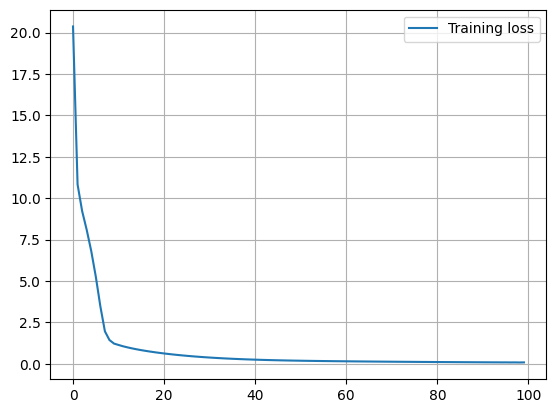

In [13]:
import matplotlib.pyplot as plt
plt.plot(hist, label="Training loss")
plt.legend()
plt.grid()
plt.show()

In [14]:
rnn.eval()
pred_test = torch.tensor([])
for i, (sequences, labels) in enumerate(test_loader):
    sequences = sequences.view(-1, window, 1)
    pred = rnn(sequences)
    pred_test = torch.cat((pred_test, pred[:,-1:,:].squeeze()), 0)
print(pred_test.shape)

torch.Size([160])


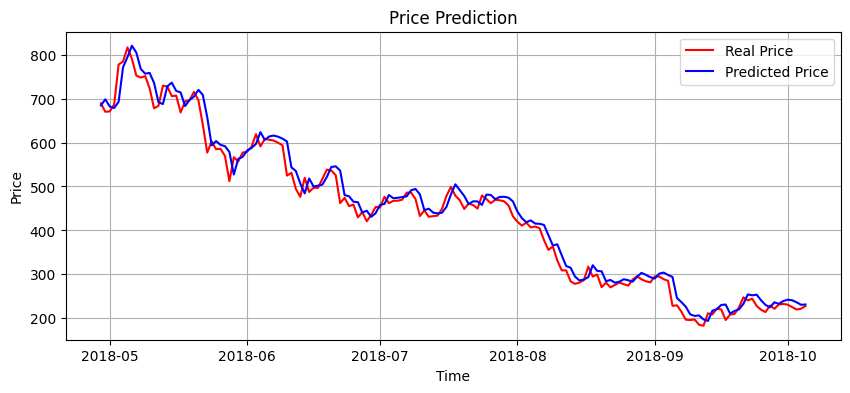

In [15]:
y1 = scaler.inverse_transform(test_data.values[-160:].reshape(160,1))
y2 = scaler.inverse_transform(pred_test.detach().numpy().reshape(160,1))
figure, axes = plt.subplots(figsize=(10, 4))
axes.xaxis_date()
axes.plot(df_data[len(df_data)-len(test_data)+30:].index, y1, color = 'red', 
          label = 'Real Price')
axes.plot(df_data[len(df_data)-len(test_data)+30:].index, y2, color = 'blue', 
          label = 'Predicted Price')
plt.title('Price Prediction')
plt.xlabel('Time'); plt.ylabel('Price'); plt.legend(); plt.grid(); plt.show()